# End-to-End Data Analysis & Modeling
- **Dataset**: `climate_nasa.csv`
- **target**: `date_dayofweek`
- **Task type**: `classification`



## 1. Setup & Imports

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, precision_recall_fscore_support, roc_auc_score
)


## 2. Load Data

In [3]:

DATA_PATH = r"C:\Users\satak\OneDrive\Desktop\Unified\climate_nasa.csv"
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]
print(df.shape)
df.head()


(522, 5)


,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."


## 3. Helper Functions

In [4]:

import math

def infer_target(df: pd.DataFrame) -> str:
    preferred_names = ["target","label","y","output","class","price","temperature","temp","anomaly","temp_anomaly","value","tavg","tmax","tmin"]
    cols_lower = {c.lower(): c for c in df.columns}
    for name in preferred_names:
        if name in cols_lower:
            return cols_lower[name]
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    for c in reversed(numeric_cols):
        if df[c].nunique(dropna=True) > 5:
            return c
    return df.columns[-1]

def detect_task(df: pd.DataFrame, target: str) -> str:
    s = df[target].dropna()
    if pd.api.types.is_numeric_dtype(s):
        unique_vals = s.unique()
        nunique = s.nunique()
        is_int_like = np.all(np.isclose(s, np.round(s), equal_nan=True))
        if (is_int_like and nunique <= max(20, int(0.05*len(s)))) or nunique <= 10:
            return "classification"
        else:
            return "regression"
    else:
        return "classification"

def find_datetime_cols(df: pd.DataFrame):
    candidates = []
    for c in df.columns:
        cl = c.lower()
        if "date" in cl or "time" in cl or "year" in cl or "month" in cl or "day" in cl:
            candidates.append(c)
    for c in df.select_dtypes(include=["object"]).columns:
        if c not in candidates:
            sample = df[c].dropna().astype(str).head(10)
            parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
            if parsed.notna().mean() >= 0.7:
                candidates.append(c)
    return list(dict.fromkeys(candidates))

def feature_engineer_dates(df: pd.DataFrame, datetime_cols):
    df_fe = df.copy()
    for c in datetime_cols:
        try:
            parsed = pd.to_datetime(df_fe[c], errors="coerce", infer_datetime_format=True)
            df_fe[c+"_year"] = parsed.dt.year
            df_fe[c+"_month"] = parsed.dt.month
            df_fe[c+"_day"] = parsed.dt.day
            df_fe[c+"_dayofweek"] = parsed.dt.dayofweek
            df_fe[c+"_is_month_start"] = parsed.dt.is_month_start.astype("float")
            df_fe[c+"_is_month_end"] = parsed.dt.is_month_end.astype("float")
        except Exception:
            pass
    return df_fe

def build_preprocessor(df: pd.DataFrame, target: str):
    X = df.drop(columns=[target])
    numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_features = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), numeric_features),
            ("cat", categorical_pipeline, categorical_features),
        ]
    )
    return preprocessor, numeric_features, categorical_features

def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"R2": r2, "RMSE": rmse, "MAE": mae, "MSE": mse}

def evaluate_classification(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    metrics = {"Accuracy": acc, "Precision_w": precision, "Recall_w": recall, "F1_w": f1}
    if y_proba is not None:
        try:
            if y_proba.ndim == 1:
                auc = roc_auc_score(y_true, y_proba)
            else:
                auc = roc_auc_score(y_true, y_proba, multi_class="ovr")
            metrics["ROC_AUC"] = auc
        except Exception:
            pass
    return metrics


## 4. EDA & Feature Engineering

In [5]:

datetime_cols = find_datetime_cols(df)
df_fe = feature_engineer_dates(df, datetime_cols)

print("Shape:", df_fe.shape)
display(df_fe.head())
print("\nMissing values (top):")
display(df_fe.isna().sum().sort_values(ascending=False).head(20).to_frame("missing_count"))

display(df_fe.select_dtypes(include=[np.number]).describe().T.head(20))


Shape: (522, 11)


C:\Users\satak\AppData\Local\Temp\ipykernel_10032\3409517541.py:37: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
C:\Users\satak\AppData\Local\Temp\ipykernel_10032\3409517541.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
C:\Users\satak\AppData\Local\Temp\ipykernel_10032\3409517541.py:37: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-co

,date,likesCount,profileName,commentsCount,text,date_year,date_month,date_day,date_dayofweek,date_is_month_start,date_is_month_end
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...,2022,9,7,2,0.0,0.0
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...,2022,9,8,3,0.0,0.0
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...,2022,9,7,2,0.0,0.0
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...,2022,9,8,3,0.0,0.0
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart...",2022,9,7,2,0.0,0.0



Missing values (top):


,missing_count
commentsCount,278
text,18
date,0
likesCount,0
profileName,0
date_year,0
date_month,0
date_day,0
date_dayofweek,0
date_is_month_start,0


,count,mean,std,min,25%,50%,75%,max
likesCount,522.0,4.720307,12.053556,0.0,0.0,1.0,4.0,126.0
commentsCount,244.0,8.696721,12.266176,1.0,2.0,5.0,10.0,93.0
date_year,522.0,2021.356322,1.118441,2020.0,2020.0,2021.0,2022.0,2023.0
date_month,522.0,9.687739,1.844274,1.0,9.0,9.0,11.0,12.0
date_day,522.0,17.511494,7.027015,1.0,15.0,16.0,23.0,31.0
date_dayofweek,522.0,2.542146,1.322747,0.0,2.0,2.0,3.0,6.0
date_is_month_start,522.0,0.030651,0.172537,0.0,0.0,0.0,0.0,1.0
date_is_month_end,522.0,0.038314,0.192138,0.0,0.0,0.0,0.0,1.0


## 5. Target & Task Detection

In [6]:

target_col = infer_target(df_fe)
task_type = detect_task(df_fe, target_col)
target_col, task_type


('date_dayofweek', 'classification')

## 6. Train/Test Split & Preprocessing

In [7]:

preprocessor, num_feats, cat_feats = build_preprocessor(df_fe, target_col)
X = df_fe.drop(columns=[target_col])
y = df_fe[target_col]
stratify = y if (task_type == "classification" and y.nunique() > 1) else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify)
len(num_feats), len(cat_feats), X_train.shape, X_test.shape


(7, 3, (417, 10), (105, 10))

## 7. Modeling

In [8]:

models = {}
if task_type == "regression":
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.001, max_iter=10000),
        "RandomForestRegressor": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
        "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
        "SVR": SVR()
    }
else:
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForestClassifier": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "SVC": SVC(probability=True)
    }

results = []
fitted = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("scale", StandardScaler(with_mean=False)), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    if task_type == "regression":
        metrics = evaluate_regression(y_test, y_pred)
    else:
        y_proba = None
        try:
            y_proba = pipe.predict_proba(X_test)
            if isinstance(y_proba, np.ndarray) and y_proba.ndim == 2 and y_proba.shape[1] == 2:
                y_proba = y_proba[:, 1]
        except Exception:
            pass
        metrics = evaluate_classification(y_test, y_pred, y_proba)
    metrics["Model"] = name
    results.append(metrics)
    fitted[name] = pipe

results_df = pd.DataFrame(results)
if task_type == "regression":
    order = ["Model","R2","RMSE","MAE","MSE"]
else:
    order = [c for c in ["Model","Accuracy","Precision_w","Recall_w","F1_w","ROC_AUC"] if c in results_df.columns]
results_df = results_df[order].sort_values(by=order[1], ascending=False)
best_model_name = results_df.iloc[0]["Model"]
best_model_name, results_df


('GradientBoostingClassifier',
                         Model  Accuracy  Precision_w  Recall_w      F1_w  \
 2  GradientBoostingClassifier  0.771429     0.751388  0.771429  0.756112   
 1      RandomForestClassifier  0.752381     0.734208  0.752381  0.735278   
 0          LogisticRegression  0.504762     0.618053  0.504762  0.429775   
 3                         SVC  0.314286     0.098776  0.314286  0.150311   
 
     ROC_AUC  
 2  0.881542  
 1  0.925670  
 0  0.717618  
 3  0.814240  )

## 8. Plots

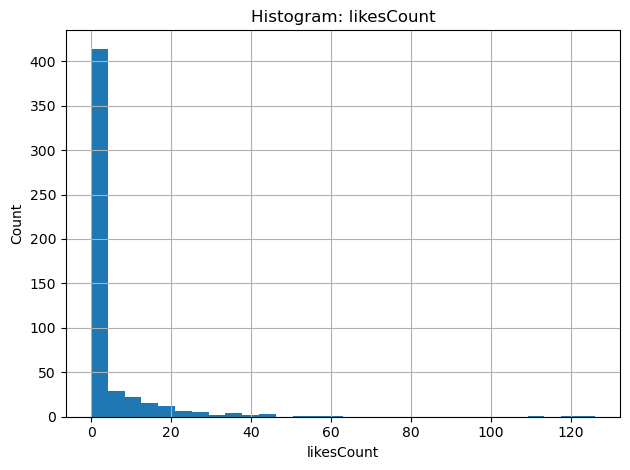

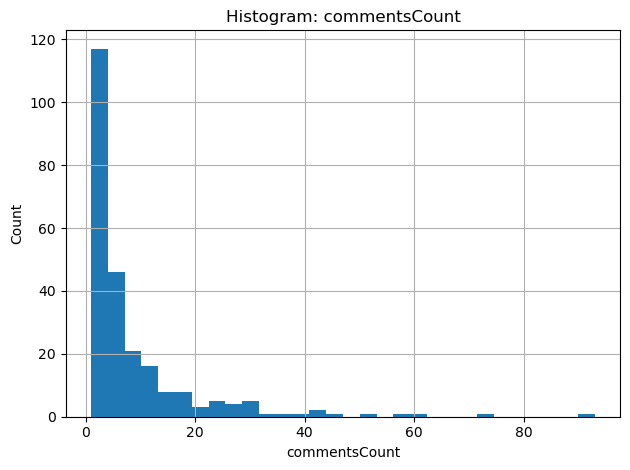

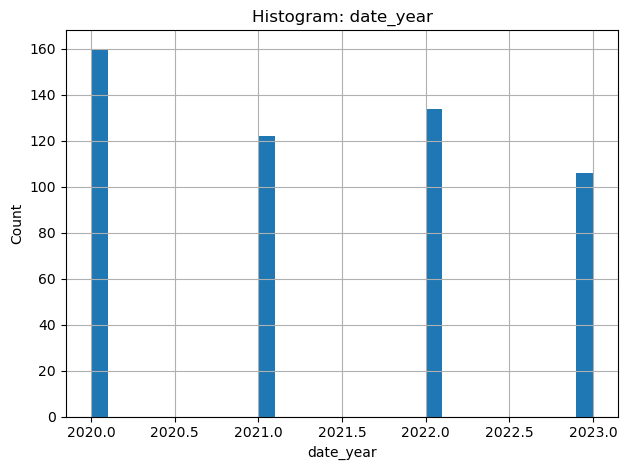

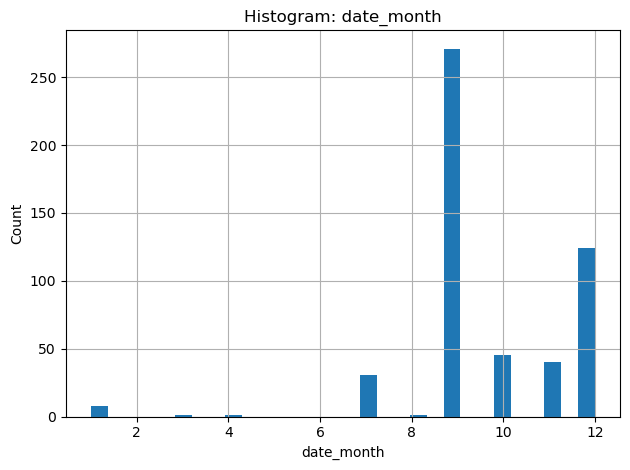

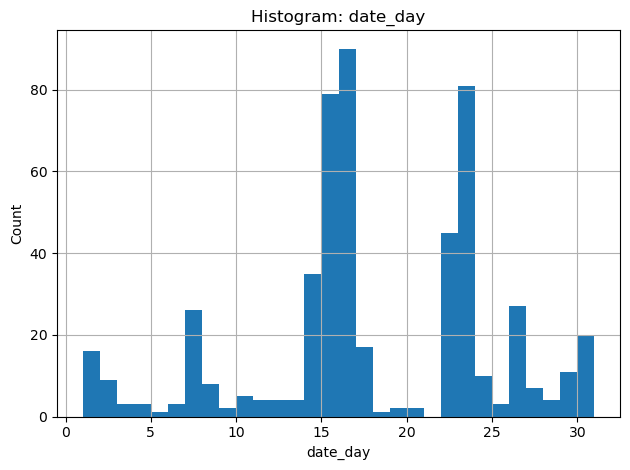

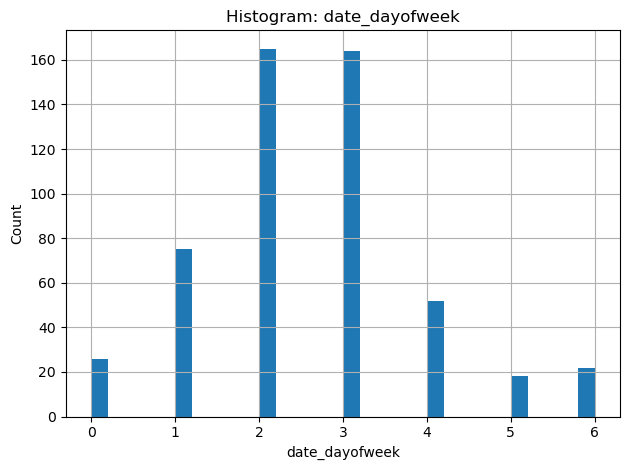

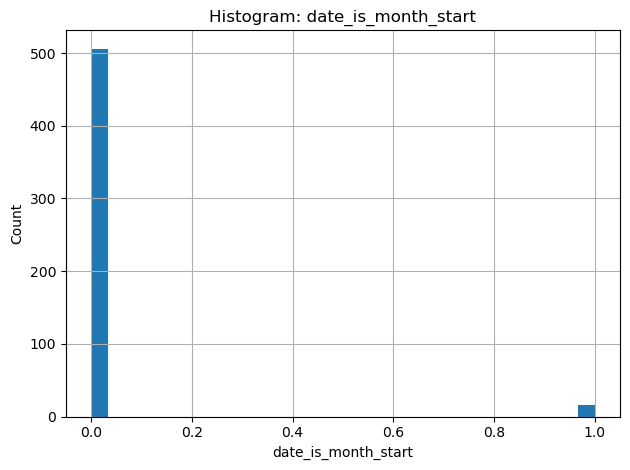

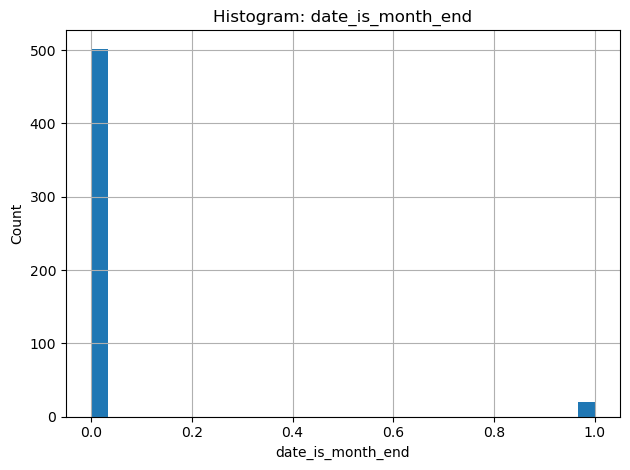

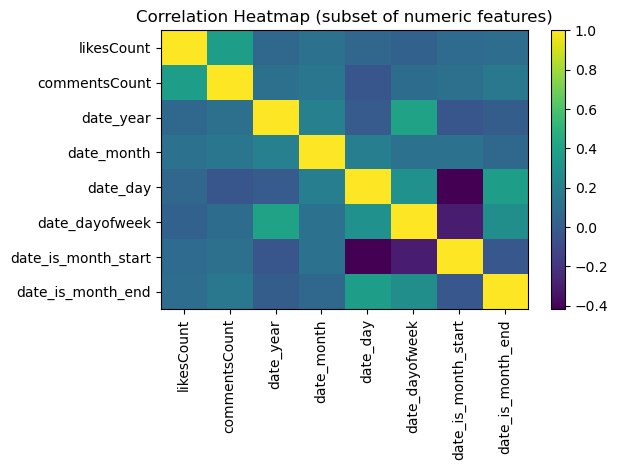

In [9]:

# Histograms for up to 9 numeric columns
numeric_cols_all = df_fe.select_dtypes(include=[np.number]).columns.tolist()
for c in numeric_cols_all[:9]:
    plt.figure()
    df_fe[c].hist(bins=30)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Correlation heatmap for up to 15 numeric columns
nc = numeric_cols_all[:15]
if len(nc) >= 2:
    corr = df_fe[nc].corr(numeric_only=True)
    plt.figure()
    im = plt.imshow(corr, aspect="auto")
    plt.colorbar(im)
    plt.xticks(range(len(nc)), nc, rotation=90)
    plt.yticks(range(len(nc)), nc)
    plt.title("Correlation Heatmap (subset of numeric features)")
    plt.tight_layout()
    plt.show()


## 9. Feature Importances

C:\Users\satak\AppData\Local\Temp\ipykernel_10032\3647374941.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


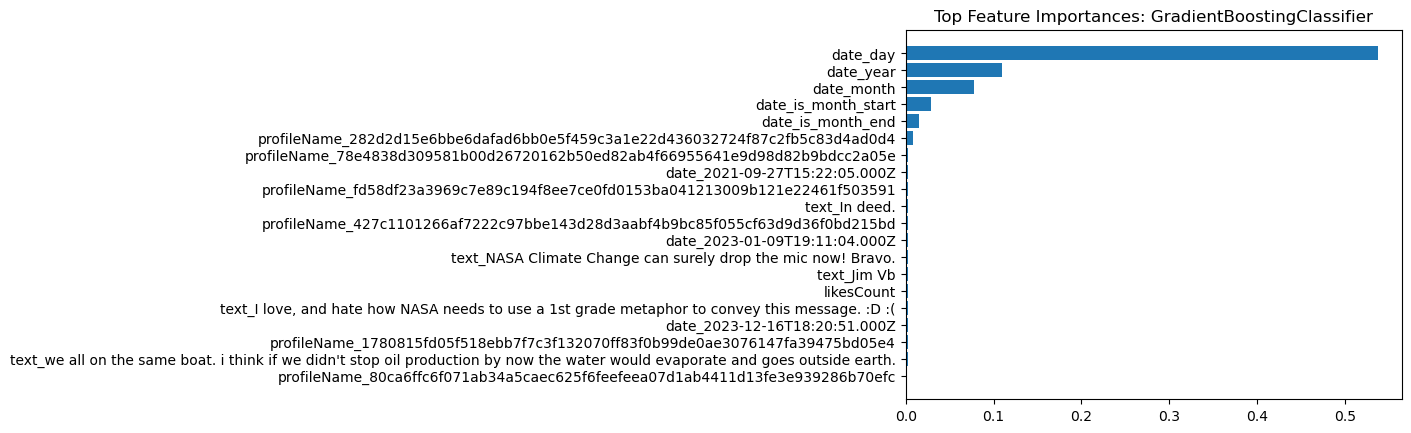

In [10]:

best_pipe = fitted[best_model_name]
model_step = best_pipe.named_steps["model"]
ohe = None
for name, trans, cols in best_pipe.named_steps["preprocess"].transformers_:
    if name == "cat":
        try:
            ohe = trans.named_steps["onehot"]
        except Exception:
            pass
num_names = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_feats = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
cat_names = []
if ohe is not None and len(cat_feats) > 0:
    try:
        cat_names = list(ohe.get_feature_names_out(cat_feats))
    except Exception:
        cat_names = []
feat_names = num_names + cat_names

if hasattr(model_step, "feature_importances_"):
    importances = model_step.feature_importances_
    if len(importances) == len(feat_names):
        import pandas as pd
        fi = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False).head(20)
        plt.figure()
        plt.barh(fi["feature"][::-1], fi["importance"][::-1])
        plt.title(f"Top Feature Importances: {best_model_name}")
        plt.tight_layout()
        plt.show()


## 10. Save Artifacts

In [12]:

# Save model comparison
results_df.to_csv(r"C:\Users\satak\OneDrive\Desktop\Unified\climate_nasa.csv", index=False)

# Preview of processed feature space size
Xt_small = preprocessor.fit_transform(X_train.head(50))
import pandas as pd
processed_preview = pd.DataFrame({
    "n_rows_transformed":[Xt_small.shape[0]],
    "n_features_transformed":[Xt_small.shape[1]]
})
processed_preview.to_csv(r"C:\Users\satak\OneDrive\Desktop\Unified\climate_nasa.csv", index=False)

print("Artifacts saved:")
print("- Model comparison:", r"C:\Users\satak\OneDrive\Desktop\Unified\climate_nasa.csv")
print("- Processed preview:", r"C:\Users\satak\OneDrive\Desktop\Unified\climate_nasa.csv")


Artifacts saved:
- Model comparison: C:\Users\satak\OneDrive\Desktop\Unified\climate_nasa.csv
- Processed preview: C:\Users\satak\OneDrive\Desktop\Unified\climate_nasa.csv
